# Contents:
1. Read images

### Import relevant libraries

In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt

### Read from Directory

In [32]:
image_size = 256
batch_size = 32

In [33]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "potato_dataset",
    labels='inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = (image_size,image_size),
    shuffle = True,
    seed= 42
)

Found 3302 files belonging to 3 classes.


In [34]:
class_names = dataset.class_names
class_names

['early_blight', 'late_blight', 'normal']

### Check if the data is balanced

In [35]:
# Create a dictionary to store class counts
class_counts = {}

# Loop through the dataset and count elements in each class
for images, labels in dataset:
    for label in labels.numpy():
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Print the counts for each class
for label, count in class_counts.items():
    print(f'Class {label}: {count}')

min_count = min(class_counts)

Class 1: 1149
Class 0: 1133
Class 2: 1020


The data is distributed in acceptable range

### Split the data

In [36]:
def split_data(dataset, train_split = 0.8, val_split = 0.1, shuffle = True, shuffle_size= 10000):
    train_count = int(len(dataset)*train_split)
    val_count = int(len(dataset)*val_split)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = 42)

    train_dataset = dataset.take(train_count)
    val_test_dataset = dataset.skip(train_count)

    validation_dataset = val_test_dataset.take(val_count)
    test_dataset = val_test_dataset.skip(val_count)

    return train_dataset, validation_dataset, test_dataset

In [37]:
train, validation, test = split_data(dataset)
print(f"train size = {len(train)}")
print(f"validation size = {len(validation)}")
print(f"test size = {len(test)}")

train size = 83
validation size = 10
test size = 11


### Cache and prefetch the data

In [38]:
train = train.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation = validation.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Produce layers for model

In [39]:
resize_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [40]:
data_augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2)
])

### Model


In [41]:
input_shape = (batch_size, image_size,image_size, 3)

def conv2D_layer(filter):
    return tf.keras.layers.Conv2D(
        filters = filter, 
        kernel_size=(3,3),
        padding="valid", # no padding
        activation="relu",
        input_shape = input_shape
    )
    

model = tf.keras.Sequential([
    # preprocessing layers
    resize_rescale_layer,
    data_augmentation_layer,

    # Convolutional layer
    conv2D_layer(128),
    tf.keras.layers.MaxPool2D((2,2)),
    conv2D_layer(64),
    tf.keras.layers.MaxPool2D((2,2)),
    conv2D_layer(64),
    tf.keras.layers.MaxPool2D((2,2)),
    conv2D_layer(64),
    tf.keras.layers.MaxPool2D((2,2)),
    conv2D_layer(32),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),

    # Dense layer
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

model.build(input_shape=input_shape)

In [42]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [43]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

EPOCHS =10

history = model.fit(
    train,
    epochs= EPOCHS,
    batch_size=batch_size,
    verbose =1,
    validation_data=validation
)

Epoch 1/10


83/83 [==============================] - 304s 4s/step - loss: 1.0701 - accuracy: 0.3947 - val_loss: 1.0546 - val_accuracy: 0.4313
Epoch 2/10
83/83 [==============================] - 315s 4s/step - loss: 1.0036 - accuracy: 0.5156 - val_loss: 0.9606 - val_accuracy: 0.5625
Epoch 3/10
83/83 [==============================] - 309s 4s/step - loss: 0.9216 - accuracy: 0.5779 - val_loss: 0.7970 - val_accuracy: 0.6969
Epoch 4/10
83/83 [==============================] - 317s 4s/step - loss: 0.7483 - accuracy: 0.7034 - val_loss: 0.5334 - val_accuracy: 0.7656
Epoch 5/10
83/83 [==============================] - 288s 4s/step - loss: 0.5670 - accuracy: 0.7730 - val_loss: 0.5631 - val_accuracy: 0.7656
Epoch 6/10
83/83 [==============================] - 322s 4s/step - loss: 0.4027 - accuracy: 0.8399 - val_loss: 0.4634 - val_accuracy: 0.8219
Epoch 7/10
83/83 [==============================] - 321s 4s/step - loss: 0.3789 - accuracy: 0.8532 - val_loss: 0.2708 - val_accuracy: 0.8750
Epoch 8/10
83/83 [======

In [44]:
model.evaluate(test)

11/11 [==============================] - 8s 630ms/step - loss: 0.1823 - accuracy: 0.9602


[0.18231211602687836, 0.9602272510528564]

### Visualization of training

In [45]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

NameError: name 'accuracy' is not defined

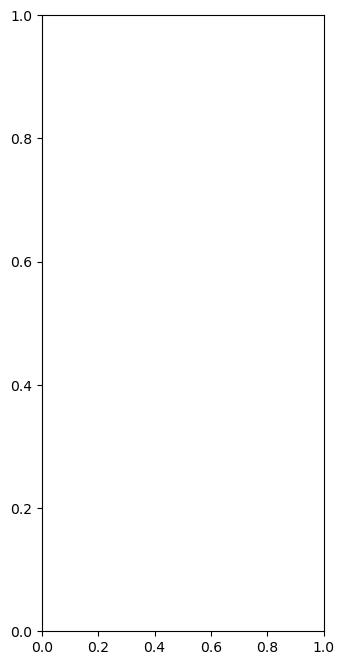

In [2]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title('Training and Validation loss')

### Prediction Function

In [ ]:
import numpy as np

def prediction(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.argmax(predictions[0])), 2)

    return predicted_class, confidence

### Save the model

In [ ]:
model_version = 1
model.save(f"../saved_models/{model_version}")